## Import Statements

In [134]:
#import packages required for the analyses
import rawpy
import imageio
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout

## Access data and preprocess

In [108]:
# specify path to 3D grayscale dataset
image_path = r'C:\Users\gkfordjour42\OneDrive - Tennessee Tech University\tensorflow\3d_project\Berea_2d25um_grayscale_filtered.raw'

In [109]:

# load the .raw 3D image file and perform validation checks to understand the type of data
def load_and_validate_raw_image(image_path, width, height, dtype=np.uint8):
    """
    This function loads a .raw image file, reshapes it based on provided dimensions and the data type,
    and performs basic validation checks to understand the data.

    The arguments are:
    - image_path: Path to the .raw image file.
    - width: Width of each slice.
    - height: Height of each slice.
    - dtype: Data type of the image data. The default is np.uint8 (adjust as necesary depending on the data).

    Returns:
    - Numpy array containing the image data, or None if validation fails.
    """
    # confirm that the specified data type is valid
    if not np.issubdtype(dtype, np.number):
        print("Error: Specified dtype is not a numerical data type.")
        return None
    #get actual size of the inputted image
    actual_size = os.path.getsize(image_path)
    #determine the bytes per volumetric pixel (voxel)
    bytes_per_voxel = np.dtype(dtype).itemsize
    #set expected sixe per slixe of the 3D image
    expected_size_per_slice = width * height * bytes_per_voxel

    # ensure the file size is an exact multiple of the slice size
    if actual_size % expected_size_per_slice != 0:
        print("Error: File size does not match expected dimensions and data type.")
        return None
    #set the depth of the image 
    depth = actual_size // expected_size_per_slice

    # load and reshape the data with the specified dimensions
    with open(image_path, 'rb') as f:
        data = np.fromfile(f, dtype=dtype)
        # consider the byte order, it is neccessary for types that may be larger than uint8
        if dtype != np.uint8: 
            data = data.astype(f'<{dtype.name}')
            #reshape the data based on the specified dimensions
        data = data.reshape((depth, height, width))
    # determine if data has been loaded successfully and view the shape of the data
    print("Data loaded successfully with dimensions:", data.shape)
    return data




## Visualize image slices of loaded data

In [114]:
def visualize_image_slices(data, num_slices=3):
    """
    This function visualize a few slices from the loaded volumetric data.

    The arguments include:
    - data: 3D numpy array of the volumetric data.
    - num_slices: Number of slices to visualize (default set to 3, can be modified).
    """
    fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))
    slice_indices = np.linspace(0, data.shape[0] - 1, num_slices, dtype=int)
    for ax, idx in zip(axes, slice_indices):
        ax.imshow(data[idx], cmap='gray')
        ax.set_title(f'Slice {idx}')
        ax.axis('on')
    plt.show()

Data loaded successfully with dimensions: (1000, 1000, 1000)


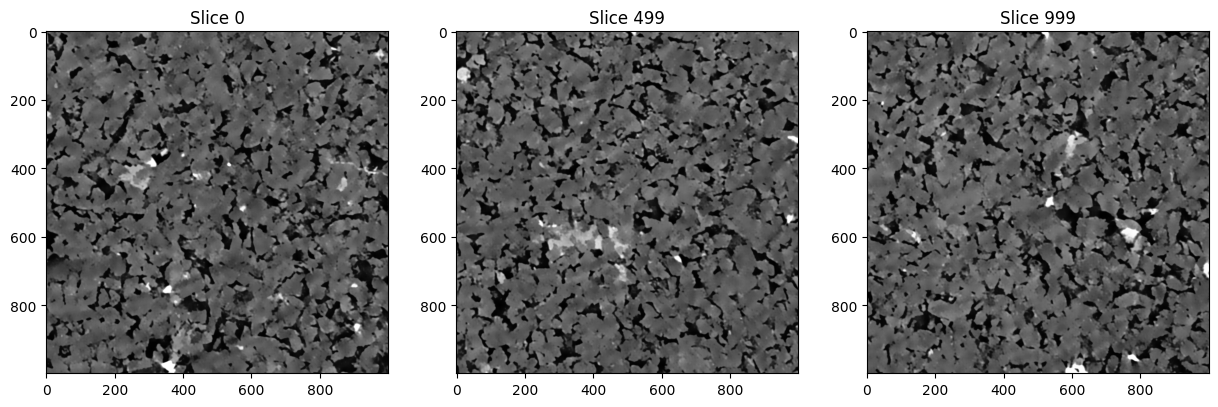

In [115]:
# load and validate the .raw image with width and height of 1000 by 1000
width, height = 1000, 1000 
#data type of 3D image
dtype = np.uint8  
#load and validate the 3D image file with image path, dimensions and data type
data = load_and_validate_raw_image(image_path, width, height, dtype=dtype)
if data is not None:
    # view 3 slices of the loaded data, can be adjusted
    visualize_image_slices(data, num_slices=3)

In [27]:
# normalize the loaded data using the min-max technique 
# normalize the volumetric pixels between 0 and 1
normalized_data = (data - np.min(data)) / (np.max(data) - np.min(data))

In [19]:
# normalized_data = np.zeros_like(data, dtype=np.float32)
# for i in range(data.shape[0]):
#     normalized_data[i] = (data[i] - np.min(data[i])) / (np.max(data[i]) - np.min(data[i]))


In [112]:
# function for extracting sub volumes at 100,100,100
def extract_sub_volumes(data, sub_volume_size=(100, 100, 100), num_sub_volumes=20):
    '''This function extracts sub-volumes from the volumetric data based on the sub-volume size passed into it
    
    
    The arguments are:
    -data: Volumetric data from which sub-volumes are to be extracted from
    -sub-volume size: The dimensions of each extracted subvolume; depth, height, and width
    -num_sub_volumes: The number of sub-volumes you intend to use (default set to 20, can be adjusted as needed)'''
    
    #set sub-volumes as an empty list
    sub_volumes = []
    #obtain original volumetric data depth, height and width
    depth, height, width = data.shape
    
    for i in range(num_sub_volumes):
        # randomly choose a starting point for the sub-volume (starting point can be adjusted as needed)
        z_start = np.random.randint(0, depth - sub_volume_size[0])
        y_start = np.random.randint(0, height - sub_volume_size[1])
        x_start = np.random.randint(0, width - sub_volume_size[2])
        
        # extract the sub-volumes
        sub_volume = data[z_start:z_start + sub_volume_size[0],
                          y_start:y_start + sub_volume_size[1],
                          x_start:x_start + sub_volume_size[2]]
        sub_volumes.append(sub_volume)
    
    return np.array(sub_volumes)

In [116]:
#extract the subvolumes using the function
sub_volumes = extract_sub_volumes(normalized_data)
sub_volumes.shape

(20, 100, 100, 100)

In [119]:
# calculate the porosity values from the volumetric dataset
def calculate_porosity(sub_volume, threshold):
    """
    This function calculates the porosity of each single sub-volume.
    
    The arguments are:
    - sub_volume (numpy.ndarray): The sub-volume data as a 3D numpy array.
    - threshold (float): The threshold to distinguish pores from solid material.
                         Volumetric pixels values (voxels) above this threshold are considered as pores (can be selected depending on the data).
    
    Returns:
    - float: The porosity of the sub-volume.
    """
    # identify the pore spaces (True for pores, False for solid)
    pore_space = sub_volume > threshold 
    # calculate the porosity
    porosity = np.sum(pore_space) / np.prod(sub_volume.shape)  
    return porosity


In [121]:
# calculate the porosity lables for each sub-volume conatained in the sub_volume list (in this case 20 sub-volumes)
#threshold value selected as 0.5 because image is grayscale (this is an assumed value, can be modified as needed)
porosity_labels = np.array([calculate_porosity(sv, 0.5) for sv in sub_volumes])

# print porosity labels obtained for each of the 20 sub-volumes
print(porosity_labels)

[0.04692  0.027223 0.027717 0.019242 0.015577 0.15148  0.035595 0.033487
 0.096852 0.017764 0.02978  0.009463 0.018719 0.009531 0.015582 0.017948
 0.016416 0.040908 0.037036 0.017053]


## Visualize sub-volumes with porosity values

In [24]:
#view the different sub-volumes and their porosity values
def visualize_sub_volumes_with_porosity(sub_volumes, porosity_labels, num_to_visualize):
    """
    This function visualizes  a specific number of sub-volumes and their porosity values.

    Arguments are:
    - sub_volumes (numpy.ndarray): Array of sub-volumes.
    - porosity_labels (numpy.ndarray): Array of porosity values corresponding to each sub-volume.
    - num_to_visualize (int): Number of sub-volumes to visualize.
    """
    # select a few sub-volumes to visualize
    indices = np.linspace(0, len(sub_volumes) - 1, num_to_visualize, dtype=int)

    # set up the plots
    fig, axs = plt.subplots(1, num_to_visualize, figsize=(15, 3))

    for i, idx in enumerate(indices):
        # select the middle slice indexes
        mid_slice_idx = sub_volumes[idx].shape[0] // 2
        mid_slice = sub_volumes[idx][mid_slice_idx]

        # plot the grayscale slices
        axs[i].imshow(mid_slice, cmap='gray')
        axs[i].title.set_text(f'Porosity: {porosity_labels[idx]:.2f}')
        axs[i].axis('on')

    plt.show()


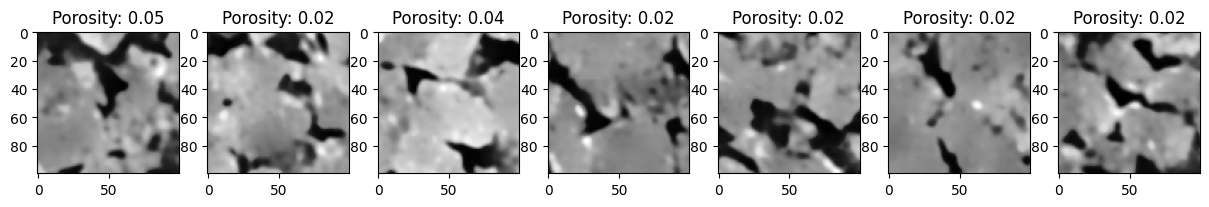

In [140]:
# call visualize function to view sub-volumes and porosity values
visualize_sub_volumes_with_porosity(sub_volumes, porosity_labels, num_to_visualize=7)

## Divide data into train, validation, and test data

In [123]:
# split the data into a combined training+validation set and a separate testing set using 80-20 split
# use random state of 42 (arbitrary) to avoid chnages when cell is rerun, can be modified as needed
X_train_val, X_test, y_train_val, y_test = train_test_split(
    sub_volumes, porosity_labels, test_size=0.20, random_state=42)

# split the combined training and validation set into distinct training and validation sets
#train, validation, test percentage - 60%, 20%, 20%, consistent random state
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.20, random_state=42)  

# adjust the shape of the train, vlaidation  and test datasets by adding a channel dimension  for the the CNN model architecture
# selecting 1 because image is grayscale, and place at the last axis
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

#view the shapes of the tarining, validaiton, and test datasets
print(f"Training set shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, Labels: {y_val.shape}")
print(f"Testing set shape: {X_test.shape}, Labels: {y_test.shape}")


Training set shape: (12, 100, 100, 100, 1), Labels: (12,)
Validation set shape: (4, 100, 100, 100, 1), Labels: (4,)
Testing set shape: (4, 100, 100, 100, 1), Labels: (4,)


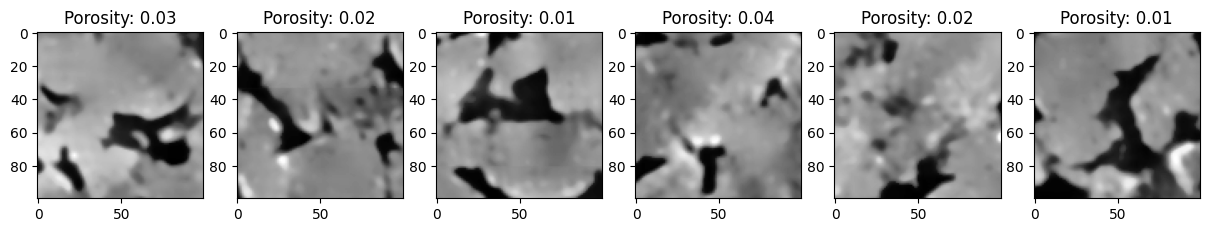

In [139]:
#view the sub-volumesnand their porosity values, 6 in this case
visualize_sub_volumes_with_porosity(X_train, y_train, num_to_visualize=6)

## Develop 3D-CNN Model

In [125]:
# build 3D CNN model with 2 convolutional layers, two maxpooling layers, a flatten layer to flatten the data,
#one hidden dense data and one output dense layer
model = Sequential([
    Conv3D(128, kernel_size=(5, 5, 5), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3], X_train.shape[4])),
    MaxPooling3D(pool_size=(4, 4, 4)),
    Conv3D(256, kernel_size=(5, 5, 5), activation='relu'),
    MaxPooling3D(pool_size=(4, 4, 4)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='linear')
])
#use adam optimizer and set learning rate (may need hypertuning)
adam= tf.keras.optimizers.Adam(learning_rate=0.00001)
#compile the model with optimizer and the mse loss function
model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mse'])


In [126]:
#view summary of compiled model
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 96, 96, 96, 128)   16128     
                                                                 
 max_pooling3d_16 (MaxPooli  (None, 24, 24, 24, 128)   0         
 ng3D)                                                           
                                                                 
 conv3d_17 (Conv3D)          (None, 20, 20, 20, 256)   4096256   
                                                                 
 max_pooling3d_17 (MaxPooli  (None, 5, 5, 5, 256)      0         
 ng3D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 32000)             0         
                                                                 
 dense_16 (Dense)            (None, 128)              

In [127]:
#train the model with a batch size of 4 and 20 epochs
history = model.fit(X_train, y_train, batch_size=4, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
3/3 [==============================] - 176s 57s/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 2/20
3/3 [==============================] - 164s 55s/step - loss: 4.1188e-04 - mse: 4.1188e-04 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 3/20
3/3 [==============================] - 163s 55s/step - loss: 5.7287e-04 - mse: 5.7287e-04 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 4/20
3/3 [==============================] - 166s 56s/step - loss: 1.3357e-04 - mse: 1.3357e-04 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 5/20
3/3 [==============================] - 164s 56s/step - loss: 2.3635e-04 - mse: 2.3635e-04 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 6/20
3/3 [==============================] - 168s 57s/step - loss: 9.9532e-05 - mse: 9.9532e-05 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 7/20
3/3 [==============================] - 167s 56s/step - loss: 7.8577e-05 - mse: 7.8577e-05 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 8/20
3/3 [==========================

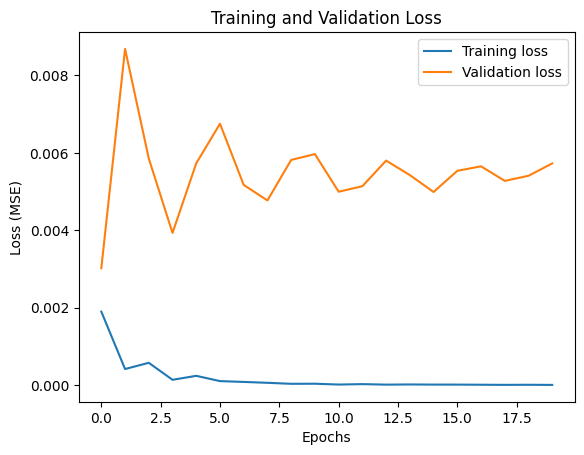

In [128]:
# view training and validation loss across the epochs
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

## Make predictions with trained model

In [130]:
# test the trained model on the test data for prediction
y_pred = model.predict(X_test)

1/1 [==============================] - 4s 4s/step


In [131]:
# flatten the predicted values to match shape of the test data
y_pred=y_pred.flatten()

In [132]:
#view the predicted and test data concurrently
y_pred.shape, y_test.shape
print("Predicted porosity values for y_pred:", y_pred)
print("Actual porosity values for y_test:", y_test)

Predicted porosity values for y_pred: [0.02082943 0.01563972 0.02171871 0.02284343]
Actual porosity values for y_test: [0.04692  0.040908 0.017948 0.027223]


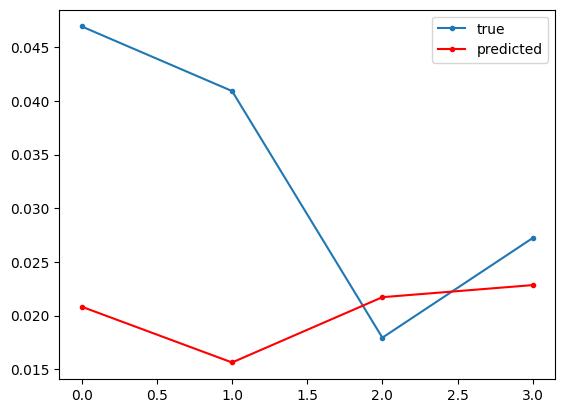

In [133]:
#visualize the test and predicted values
plt.plot(y_test, marker='.', label='true')
plt.plot(y_pred.flatten(), 'r' ,marker='.', label='predicted')
plt.title('Comparison of True vs. Predicted Porosity Values')
plt.legend()

In [138]:
# calculate the RMSE of the predicted values 
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('RMSE of predicted porosity values:', rmse)

RMSE of predicted porosity values: 0.018388872466218682
